In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import networkx as nx
from IPython.display import Math
from pgmpy.estimators import PC # %pip install pgmpy
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from dotenv import load_dotenv
from sklearn.model_selection import KFold
from sklearn.covariance import GraphicalLasso
from numpy.linalg import slogdet
os.chdir("..")

load_dotenv("globs.env")
tickers   = os.getenv("TICKERS").split(",")
media_dir = os.getenv("MEDIA_DIR")
data_dir  = os.getenv("DATA_DIR")

import logging
from scripts.utils import log

LOG_FILE = "logs/pc_algorithm.log"

class PgmpyToUtils(logging.Handler):
    def emit(self, record):
        log(record.getMessage(), LOG_FILE, level=record.levelname, echo=False)

pgmpy_logger = logging.getLogger("pgmpy")
pgmpy_logger.propagate = False
pgmpy_logger.handlers.clear()
pgmpy_logger.addHandler(PgmpyToUtils())
pgmpy_logger.setLevel(logging.INFO)

In [2]:
## Load data
df = pd.read_csv(data_dir + "/returns.csv").set_index("date").ffill() # handle NaN

df = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
X = (df - df.mean()) / df.std(ddof=0)
n, p = X.shape
print(f"n x p:", (n, p))

n x p: (1222, 15)


In [3]:
def fisher_z_ci_test(X, i, j, cond_set=None, significance_level=0.05):
    """
    Fisher-Z conditional independence test
    """
    cond_set = [] if cond_set is None else list(cond_set)
    cols = [i, j] + cond_set
    data = X[cols].dropna()

    corr = np.corrcoef(data.values, rowvar=False)
    try:
        prec = np.linalg.inv(corr)
    except np.linalg.LinAlgError:
        return False  # treat as dependent if singular

    rho = -prec[0, 1] / np.sqrt(prec[0, 0] * prec[1, 1])
    n = data.shape[0]
    z = 0.5 * np.log((1 + rho) / (1 - rho))
    stat = np.sqrt(max(n - len(cond_set) - 3, 1)) * abs(z)
    crit = norm.ppf(1 - significance_level / 2)
    return stat <= crit  # True = independent

def run_pc(X, alpha):
    pc = PC(X)

    def ci_wrapper(x, y, z, **kwargs):
        return fisher_z_ci_test(X, x, y, z, significance_level=alpha)

    model = pc.estimate(
        significance_level=alpha,
        ci_test=ci_wrapper,
        n_jobs=1,
        show_progress=False
    )

    # Extract graph in a robust way
    if isinstance(model, (nx.Graph, nx.DiGraph)):
        G = model
    elif hasattr(model, "to_networkx"):
        G = model.to_networkx()
    elif hasattr(model, "to_digraph"):
        G = model.to_digraph()
    elif hasattr(model, "graph") and model.graph is not None:
        G = model.graph
    elif isinstance(model, dict) and "graph" in model:
        G = model["graph"]
    else:
        # manual fallback
        G = nx.DiGraph()
        try:
            G.add_nodes_from(model.nodes)
            G.add_edges_from(model.edges)
        except Exception as e:
            raise TypeError(f"Could not extract graph structure: {e}")

    return G, {"Nodes": len(G.nodes()), "Edges": len(G.edges())}

def plot_graph(G, title, ax=None):
    pos = nx.spring_layout(G, seed=42, k=3, iterations=300)

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 7))

    nx.draw_networkx_edges(
        G, pos, ax=ax,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=12,
        width=1.5,
        edge_color="gray",
        connectionstyle="arc3,rad=0.1",
        alpha=0.5
    )
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=450,
        node_color="lightsteelblue",
        edgecolors="black",
        linewidths=1.0,
        alpha=0.5
    )
    nx.draw_networkx_labels(
        G, pos, ax=ax,
        font_size=6,
        font_weight="semibold",
        font_color="black"
    )

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(title, fontsize=12, pad=8)

100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


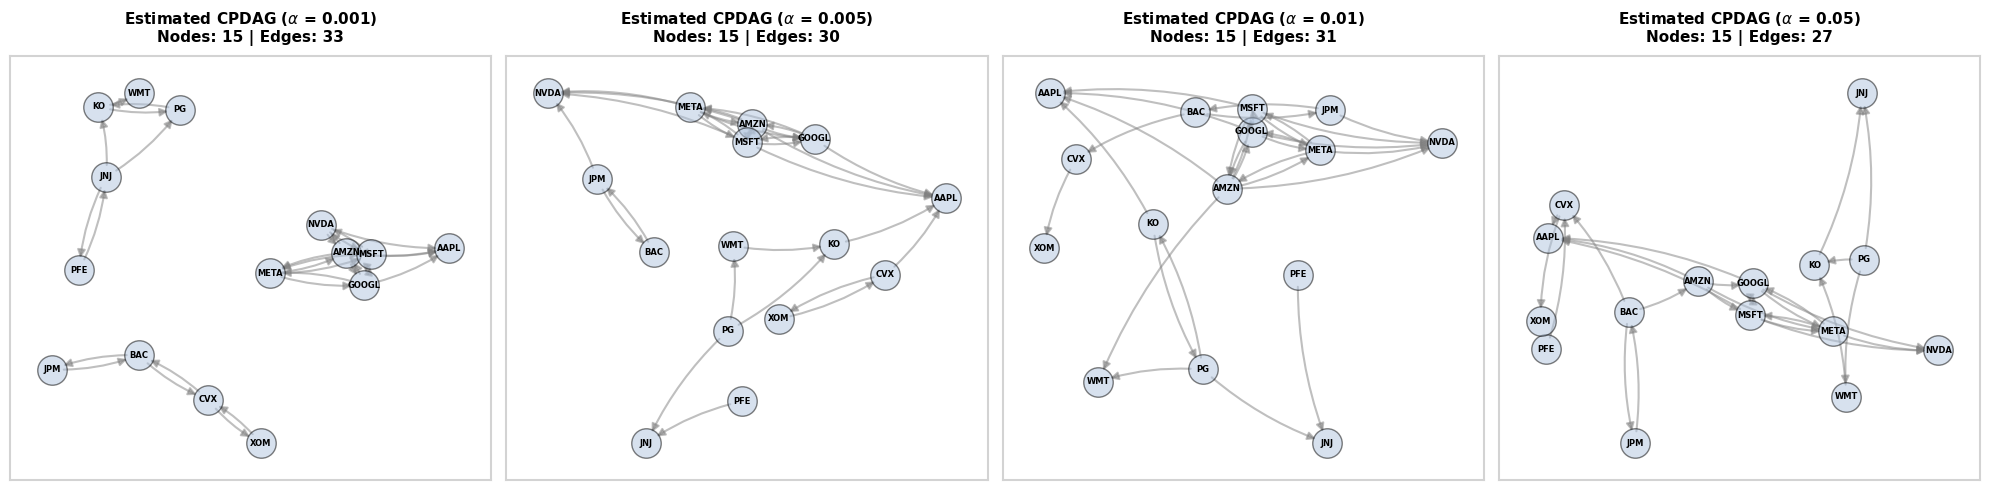

In [4]:
# Run PC for several α levels
alphas = [0.001, 0.005, 0.01, 0.05]
graphs = {}
k = len(alphas)

fig, axes = plt.subplots(1, len(alphas), figsize=(5*len(alphas), 5))
for ax, alpha in tqdm(zip(axes, alphas), total=len(alphas)):
    G, dict_ = run_pc(X, alpha)
    graphs[alpha] = G
    plot_graph(G, "", ax=ax)
    ax.set_title(
        rf"Estimated CPDAG ($\alpha$ = {alpha})" "\n"
        rf"Nodes: {dict_['Nodes']} | Edges: {dict_['Edges']}",
        fontsize=11,
        pad=10,
        backgroundcolor="white",
        fontweight="semibold"
    )
    ax.set_frame_on(True)
    for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(media_dir + "/pc_algorithm_on_alpha_grid.png")
plt.show()

In [7]:
def gaussian_loglik(X, Theta):
    S = np.cov(X, rowvar=False)
    sign, logdet = slogdet(Theta)
    if sign <= 0:
        return -np.inf
    return logdet - np.trace(S @ Theta)

def cv_pc_alpha(X, alpha_grid, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    cv_scores = {a: [] for a in alpha_grid}

    for alpha in alpha_grid:
        for train_idx, val_idx in kf.split(X):
            X_train = X.iloc[train_idx, :]
            X_val   = X.iloc[val_idx, :]
            G, _ = run_pc(X_train, alpha)                      # Run PC
            adj = nx.to_numpy_array(G)                         # Convert to adjacency matrix
            S_train = np.cov(X_train, rowvar=False)            # Gaussian model: Glasso on training covariance
            gl = GraphicalLasso(alpha=0.01, max_iter=200).fit(S_train)
            Theta = gl.precision_
            Theta = Theta * adj                                # Enforce PC zero pattern
            np.fill_diagonal(Theta, gl.precision_.diagonal())
            ll = gaussian_loglik(X_val.values, Theta)          # Validation log-likelihood
            cv_scores[alpha].append(ll)
    avg_scores = {a: np.mean(cv_scores[a]) for a in alpha_grid}
    return avg_scores, cv_scores


alpha_grid = [0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05]
avg_scores, folds = cv_pc_alpha(X, alpha_grid)

print("Average CV log-likelihood:")
for a in alpha_grid:
    print(a, avg_scores[a])

alpha_star = max(avg_scores, key=avg_scores.get)
Math(rf"Selected\ \alpha = {alpha_star}")

Average CV log-likelihood:
0.0005 -477.8042570237015
0.001 -479.717617755033
0.0025 -466.3977655457244
0.005 -490.16407351781817
0.0075 -483.0289894302511
0.01 -471.65847023110325
0.025 -460.56046242463145
0.05 -454.14807325309977


<IPython.core.display.Math object>

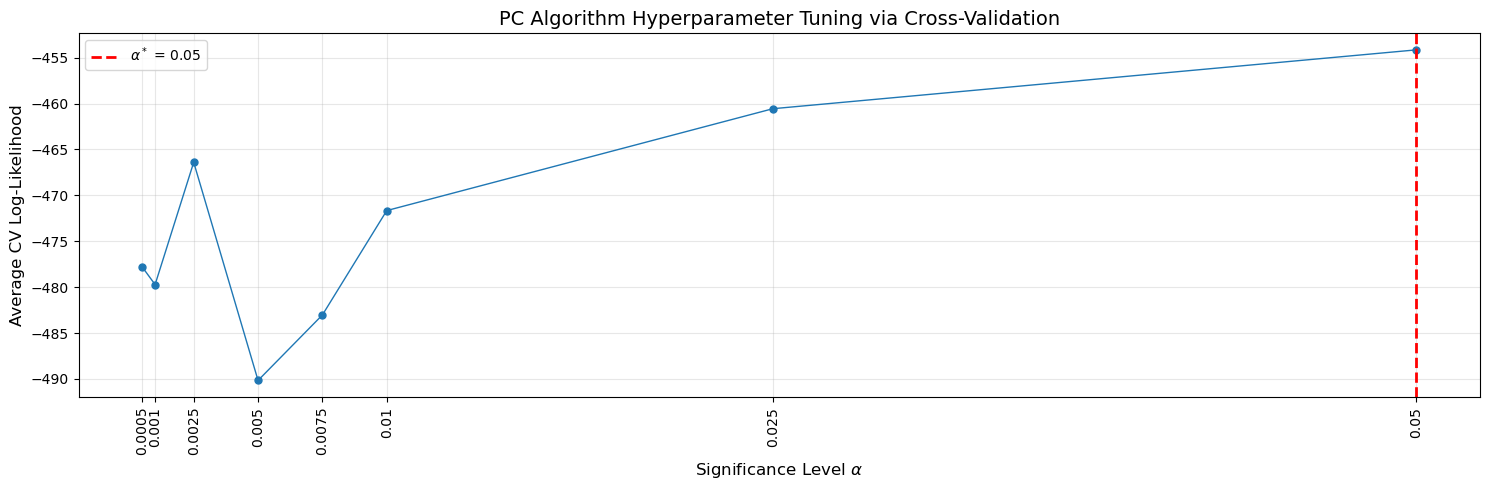

In [24]:
alphas = np.array(alpha_grid)
scores = np.array([avg_scores[a] for a in alpha_grid])

plt.figure(figsize=(15, 5))
plt.plot(alphas, scores, marker='o', linewidth=1, markersize=5)
plt.xlabel(r"Significance Level $\alpha$", fontsize=12)
plt.ylabel("Average CV Log-Likelihood", fontsize=12)
plt.title("PC Algorithm Hyperparameter Tuning via Cross-Validation", fontsize=14)
plt.axvline(alpha_star, color='red', linestyle='--', linewidth=2, label=fr"$\alpha^*$ = {alpha_star}")
plt.xticks(alphas, alphas, rotation=90)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(media_dir + "/CV_pc_algo.png")
plt.show()

In [9]:
def pc_algorithm_hyperparameter_tuning(
    X, alpha_star=0.001, B=300,
    thr_list = [0.75, 0.90, 0.95, 0.99, 1.0],
    savepath1=None, 
):
    n, p = X.shape
    nodes = list(X.columns)
    node_index = {node: idx for idx, node in enumerate(nodes)}
    print(f"Using chosen alpha_star = {alpha_star}")

    # Fit PC at alpha_star
    G_full, stats_full = run_pc(X, alpha_star)
    print(f"Full-data PC graph: nodes={stats_full['Nodes']} edges={stats_full['Edges']}")

    # Build adjacency matrix
    A_full = np.zeros((p, p), dtype=int)
    for (u, v) in G_full.to_undirected().edges():
        i = node_index[u]
        j = node_index[v]
        A_full[i, j] = 1
        A_full[j, i] = 1

    # Stability selection (bootstrap)
    print(f"Running PC bootstrap with B={B}...")

    sel_counts = np.zeros((p, p))

    for b in tqdm(range(B), desc="Bootstrapping PC"):
        idx = np.random.choice(n, size=n, replace=True)
        Xb = X.iloc[idx, :]

        Gb, _ = run_pc(Xb, alpha_star)

        Ab = np.zeros((p, p), dtype=int)
        for (u, v) in Gb.to_undirected().edges():
            i = node_index[u]
            j = node_index[v]
            Ab[i, j] = 1
            Ab[j, i] = 1

        sel_counts += Ab

    freq = sel_counts / B
    np.fill_diagonal(freq, 0.0)

    # Plot stability frequency heatmap + thresholded adjacencies

    m = 1 + len(thr_list)
    fig, axes = plt.subplots(1, m, figsize=(4*m, 5))
    cmap_bw = ListedColormap(["white", "black"])

    # Frequency heatmap
    sns.heatmap(
        freq, vmin=0, vmax=1, cmap="viridis", square=True,
        xticklabels=nodes, yticklabels=nodes,
        cbar_kws={"shrink": 0.5, "label": "Selection frequency"},
        ax=axes[0]
    )
    axes[0].set_title(f"PC edge selection frequency (B={B})")
    axes[0].tick_params(labelsize=8)
    axes[0].tick_params(axis='x', rotation=90)

    # Thresholded stable graphs
    for i_plot, thr in enumerate(thr_list, start=1):
        A_thr = (freq >= thr).astype(int)
        np.fill_diagonal(A_thr, 0)

        ecount = int(np.sum(np.triu(A_thr, 1)))

        ax = axes[i_plot]
        ax.imshow(A_thr, cmap=cmap_bw, vmin=0, vmax=1)
        ax.set_title(f"Stable edges ≥ {thr}\n(edges={ecount})")
        ax.set_xticks(range(p))
        ax.set_yticks(range(p))
        ax.set_xticklabels(nodes, rotation=90, fontsize=7)
        ax.set_yticklabels(nodes, fontsize=7)

    plt.tight_layout()

    if savepath1:
        plt.savefig(savepath1, dpi=150)

    plt.show()

    return {
        "graph_full": G_full,
        "A_full": A_full,
        "freq": freq
    }


Using chosen alpha_star = 0.05
Full-data PC graph: nodes=15 edges=27
Running PC bootstrap with B=50...


Bootstrapping PC: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


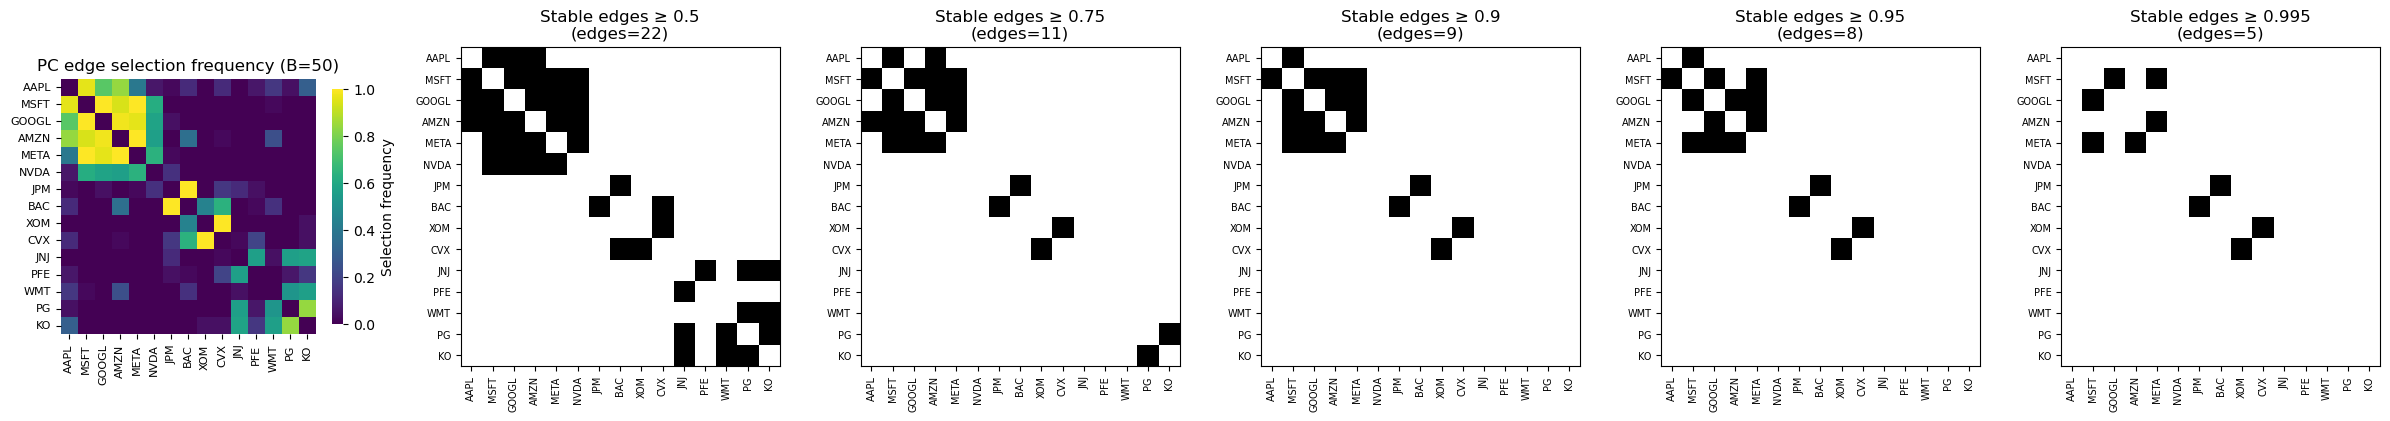

In [10]:
pc_results = pc_algorithm_hyperparameter_tuning(
    X,
    alpha_star=0.05,
    B = 50,
    thr_list = [0.5, 0.75, 0.90, 0.95, 0.995],
    savepath1=media_dir + "/pc_stability.png"
)